# Titanic

https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

## 1. Import libraries and load datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.family'] = 'Avenir'

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check Data

### 2.1 Load data

In [2]:
# Load data
#### Load train and Test datasets

train = pd.read_csv('~/aiffel/data/titanic_train.csv')
test = pd.read_csv('~/aiffel/data/titanic_test.csv')
IDtest = test['PassengerId']

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 2.2 Outlier detection

In [5]:
# Outlier detection

def detect_outliers(df, n, features):
    '''
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    '''
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # Outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # Append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # Select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

# Detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

In [6]:
# show the outliers
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


PassenderId 28, 89, and 342 have high Fare amount.

The others have high SibSp number.

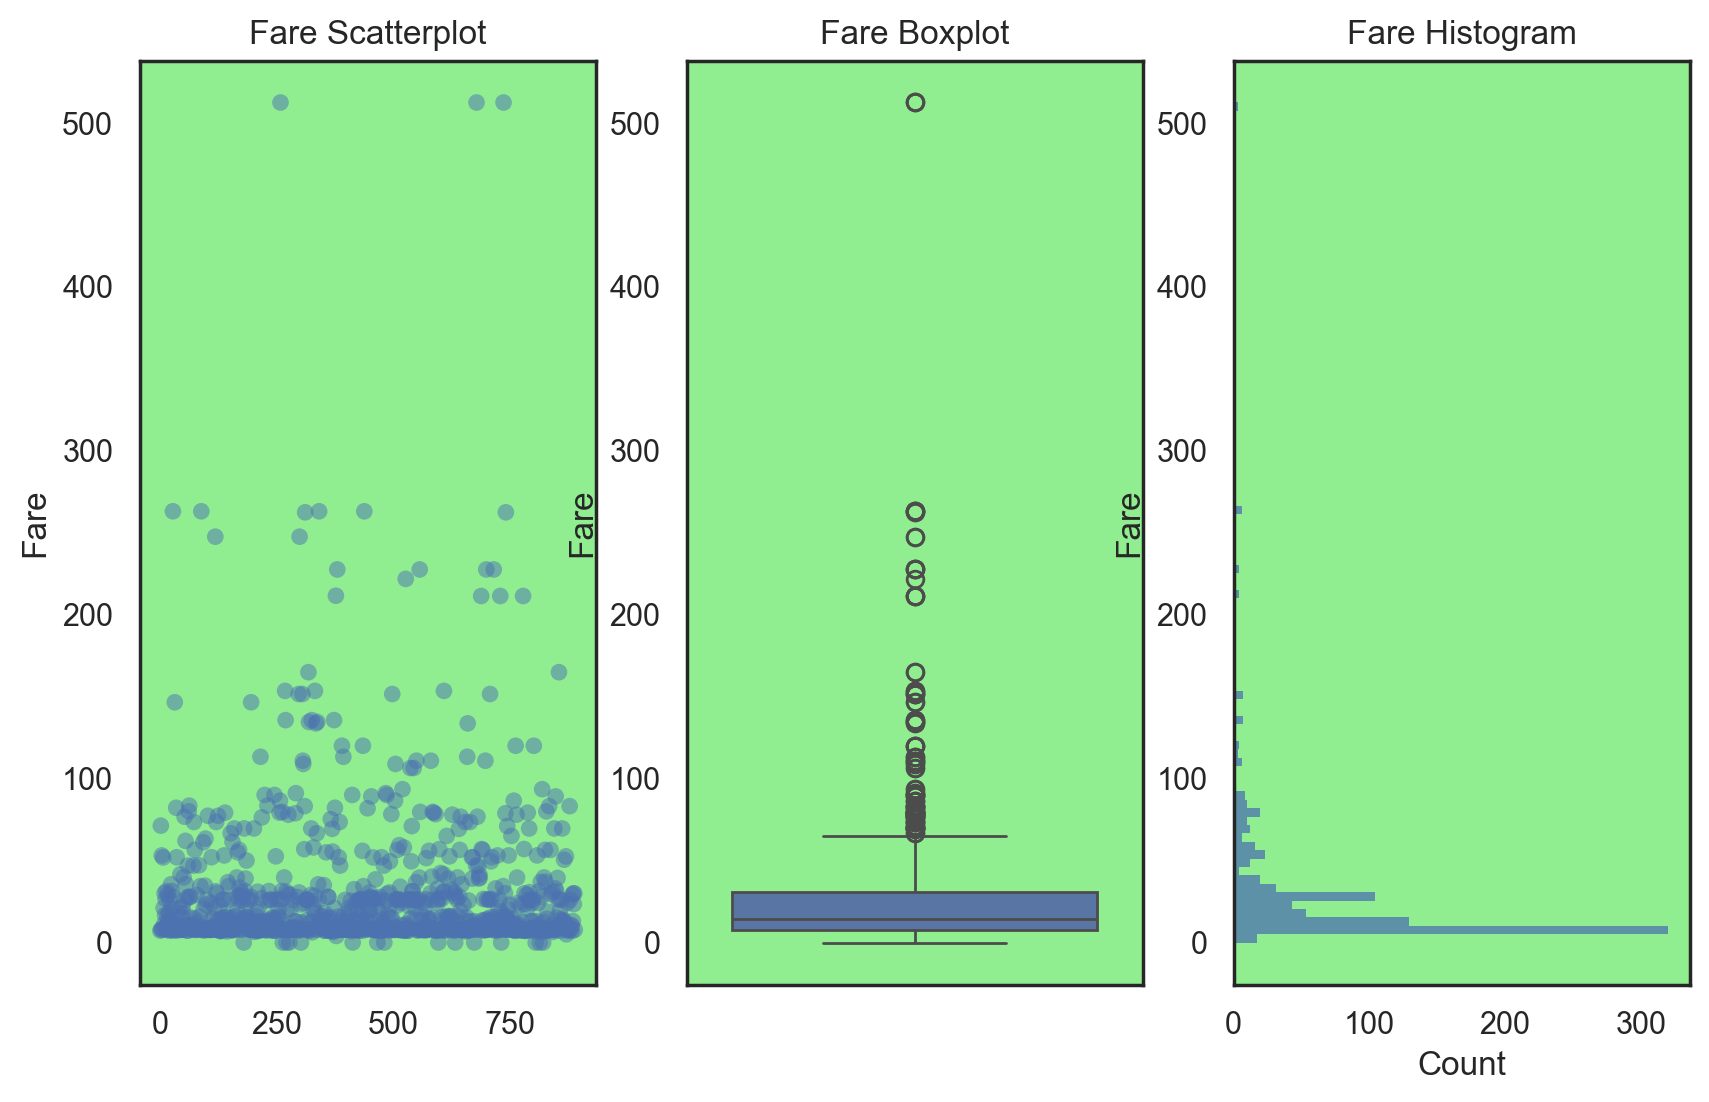

In [7]:
f, ax = plt.subplots(1, 3, figsize = (10, 6))

sns.scatterplot(x = train.index, y = 'Fare', data = train, ax = ax[0], alpha = 0.5, edgecolor = 'none')
ax[0].set_title('Fare Scatterplot')
ax[0].set_xlabel('')
ax[0].set_facecolor('lightgreen')

sns.boxplot(y = 'Fare', data = train, ax = ax[1])
ax[1].set_title('Fare Boxplot')
ax[1].set_facecolor('lightgreen')


sns.histplot(y = 'Fare', data = train, bins = 100, edgecolor = 'none', ax = ax[2])
ax[2].set_title('Fare Histogram')
ax[2].set_facecolor('lightgreen')

In [8]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [9]:
Q1 = np.percentile(train['Fare'], 25)
Q3 = np.percentile(train['Fare'], 75)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR
outlier_low = Q1 - outlier_step
outlier_high = Q3 + outlier_step

print('Q1:', Q1)
print('Q3:', Q3)
print('IQR:', IQR)
print('outlier_step:', outlier_step)
print('outlier_low:', outlier_low)
print('outlier_high:', outlier_high)

Q1: 7.9104
Q3: 31.0
IQR: 23.0896
outlier_step: 34.6344
outlier_low: -26.724
outlier_high: 65.6344


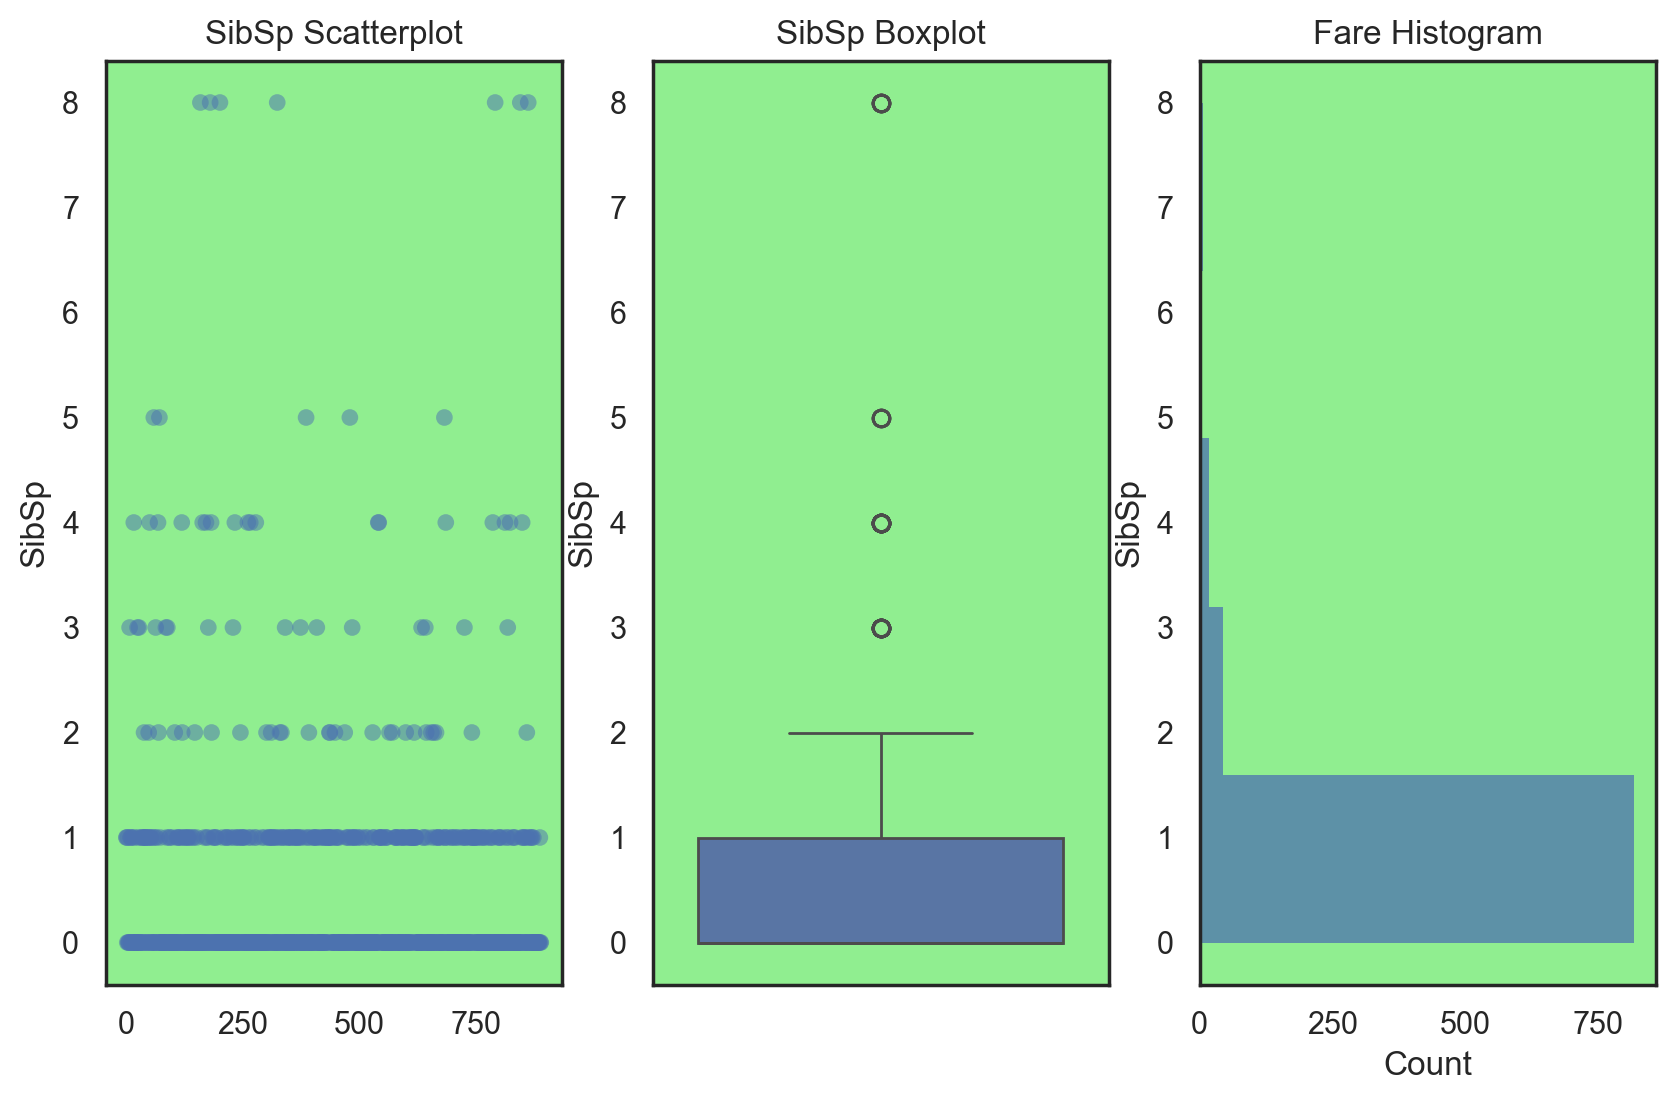

In [10]:
f, ax = plt.subplots(1, 3, figsize = (10, 6))

sns.scatterplot(x = train.index, y = 'SibSp', data = train, ax = ax[0], alpha = 0.5, edgecolor = 'none')
ax[0].set_title('SibSp Scatterplot')
ax[0].set_xlabel('')
ax[0].set_facecolor('lightgreen')

sns.boxplot(y = 'SibSp', data = train, ax = ax[1])
ax[1].set_title('SibSp Boxplot')
ax[1].set_facecolor('lightgreen')


sns.histplot(y = 'SibSp', data = train, bins = 5, edgecolor = 'none', ax = ax[2])
ax[2].set_title('Fare Histogram')
ax[2].set_facecolor('lightgreen')

In [11]:
train['SibSp'].describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

In [12]:
Q1 = np.percentile(train['SibSp'], 25)
Q3 = np.percentile(train['SibSp'], 75)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR
outlier_low = Q1 - outlier_step
outlier_high = Q3 + outlier_step

print('Q1:', Q1)
print('Q3:', Q3)
print('IQR:', IQR)
print('outlier_step:', outlier_step)
print('outlier_low:', outlier_low)
print('outlier_high:', outlier_high)

Q1: 0.0
Q3: 1.0
IQR: 1.0
outlier_step: 1.5
outlier_low: -1.5
outlier_high: 2.5


In [13]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)

### 2.3 Joining train and test set

In [14]:
# Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs = [train, test], axis = 0).reset_index(drop = True)

In [15]:
train_len

881

In [16]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1295,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1296,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1297,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### 2.4 Check for null and missing values

In [18]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [19]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [20]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [21]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [23]:
# Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis

### 3.1 Numerical values

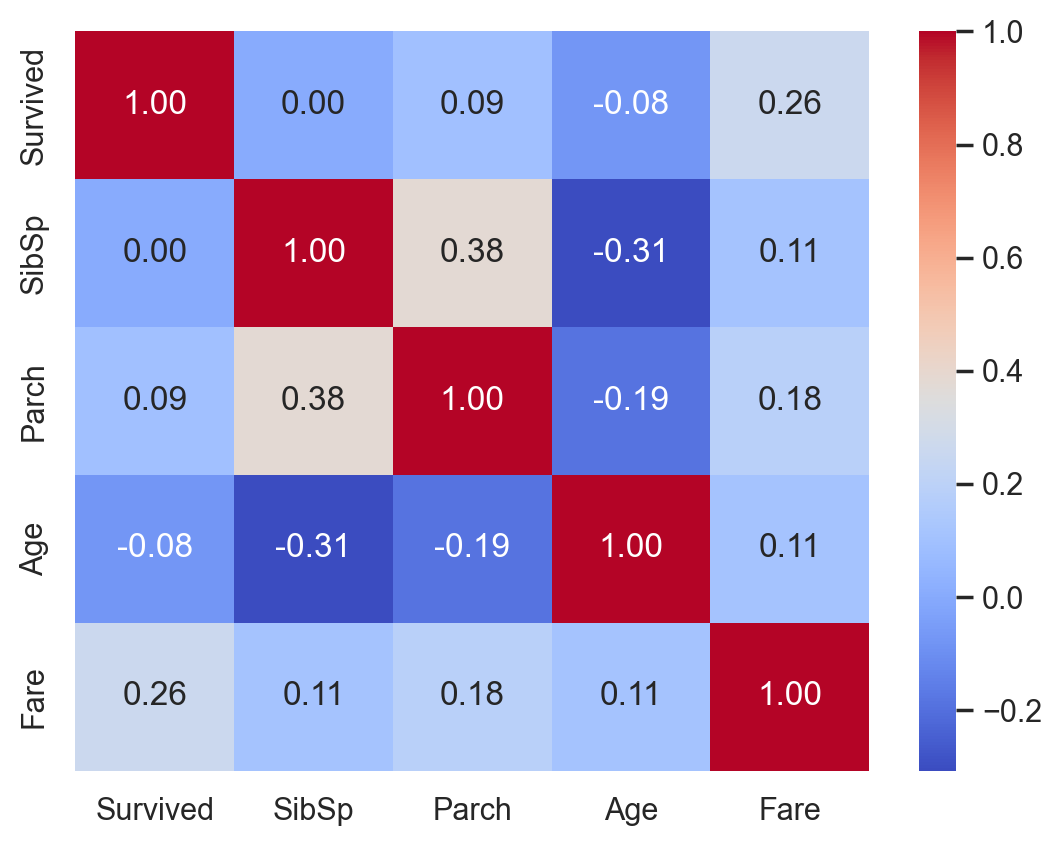

In [24]:
# Correlation matrix between numerical values (SibSp, Parch, Age, and Fare values) and Survived

g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

### SibSp

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_12893/2069855596.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height=4, palette='muted')


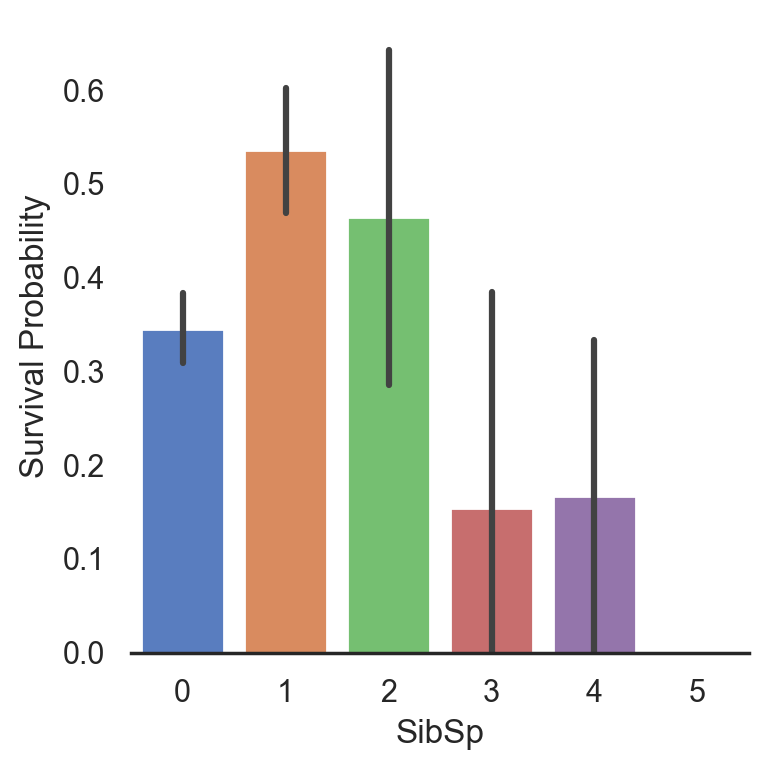

In [29]:
# Explore SibSp feature vs Survived
g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height=4, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')


### Parch

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_12893/2515774204.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x = 'Parch', y = 'Survived', data = train, kind = 'bar', height = 4, palette = 'muted')


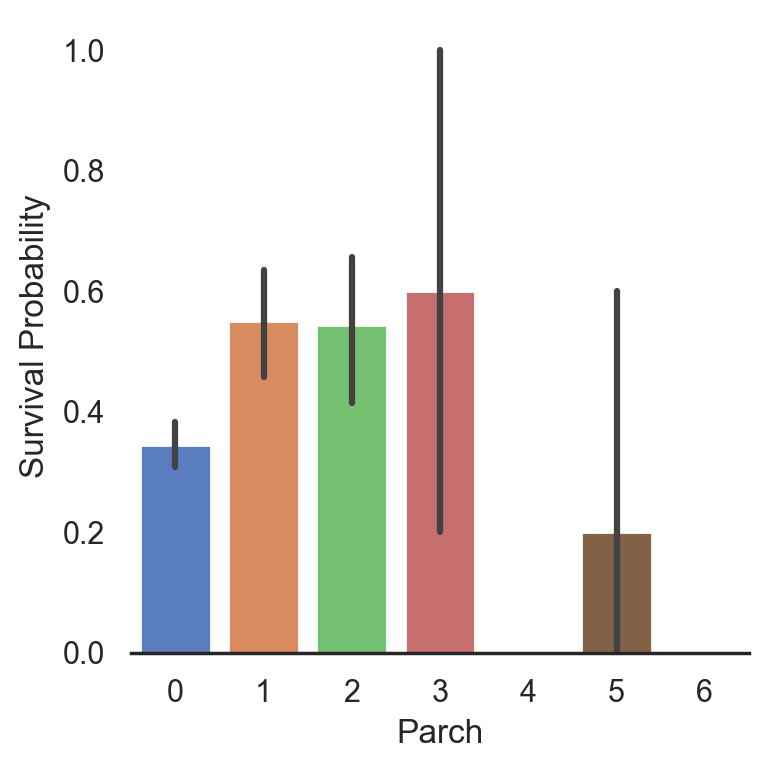

In [33]:
g = sns.catplot(x = 'Parch', y = 'Survived', data = train, kind = 'bar', height = 4, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival Probability')

### Age

/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_

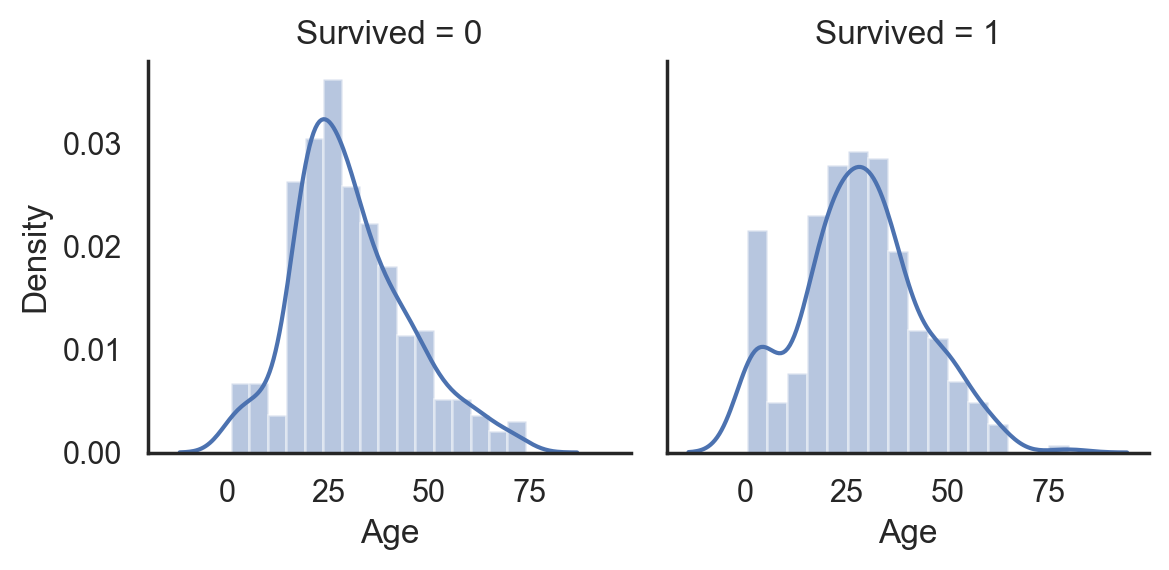

In [35]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, 'Age')

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_12893/2280496246.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade = True)
/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_12893/2280496246.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax = g, color = 'Green', shade = True)


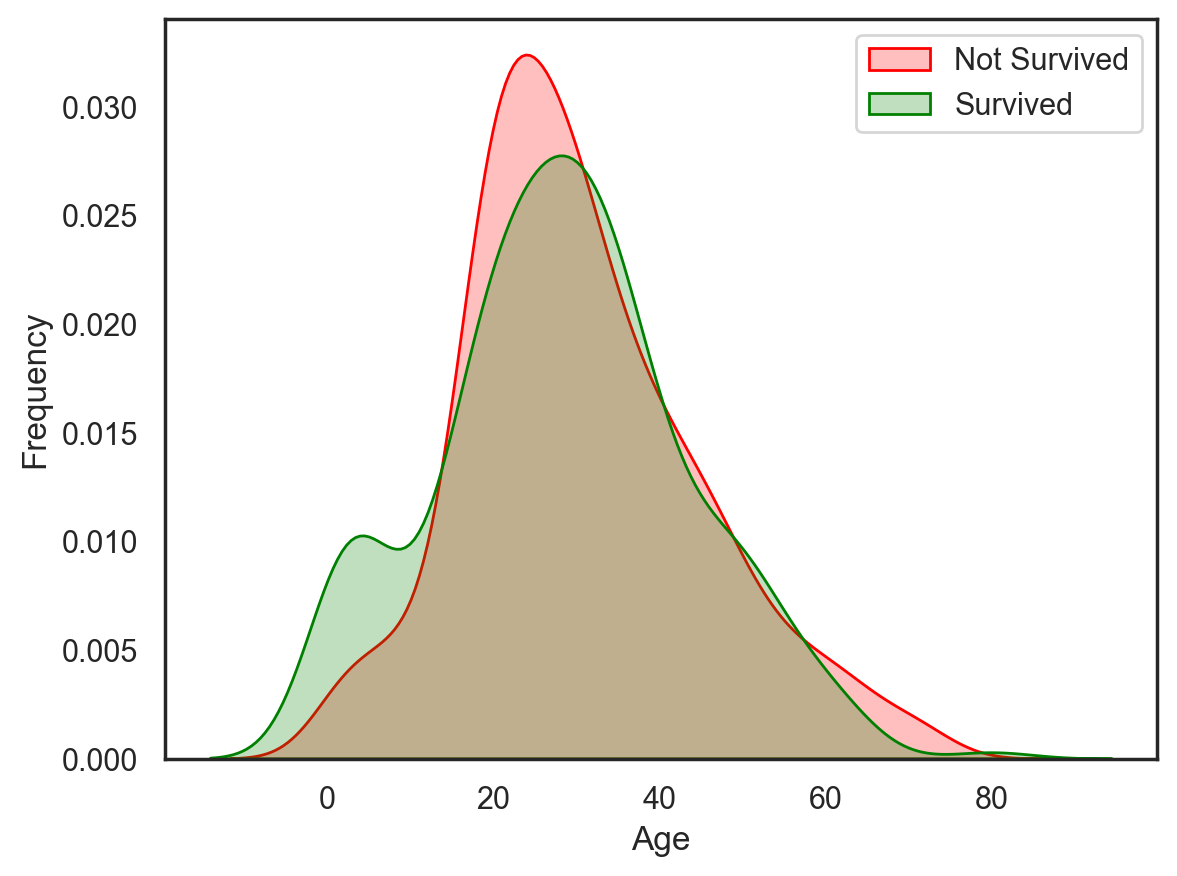

In [39]:
# Explore Age distribution
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax = g, color = 'Green', shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

### Fare

In [42]:
dataset['Fare'].isnull().sum()

0

In [41]:
# Fill Fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_12893/220858037.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))


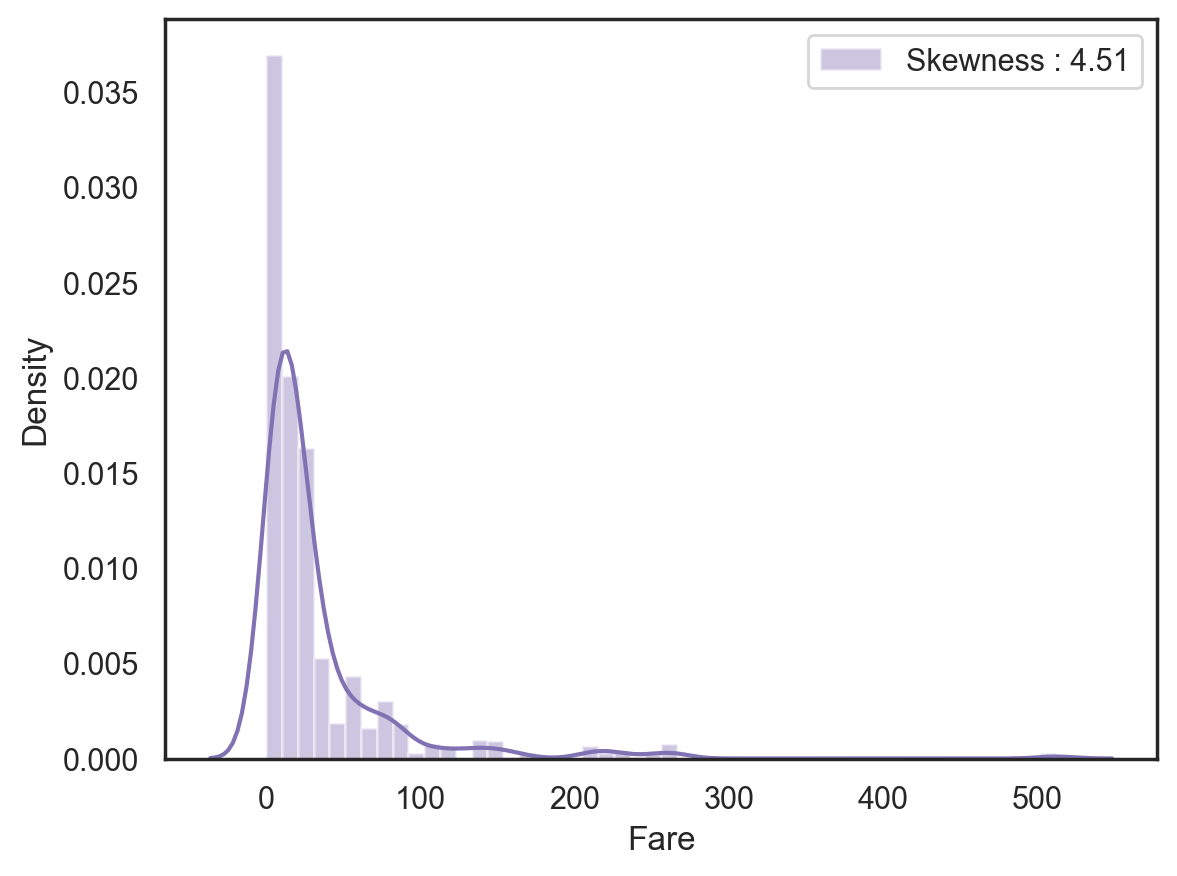

In [48]:
# Explore Fare distribution
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

In [49]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_12893/1965388384.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))


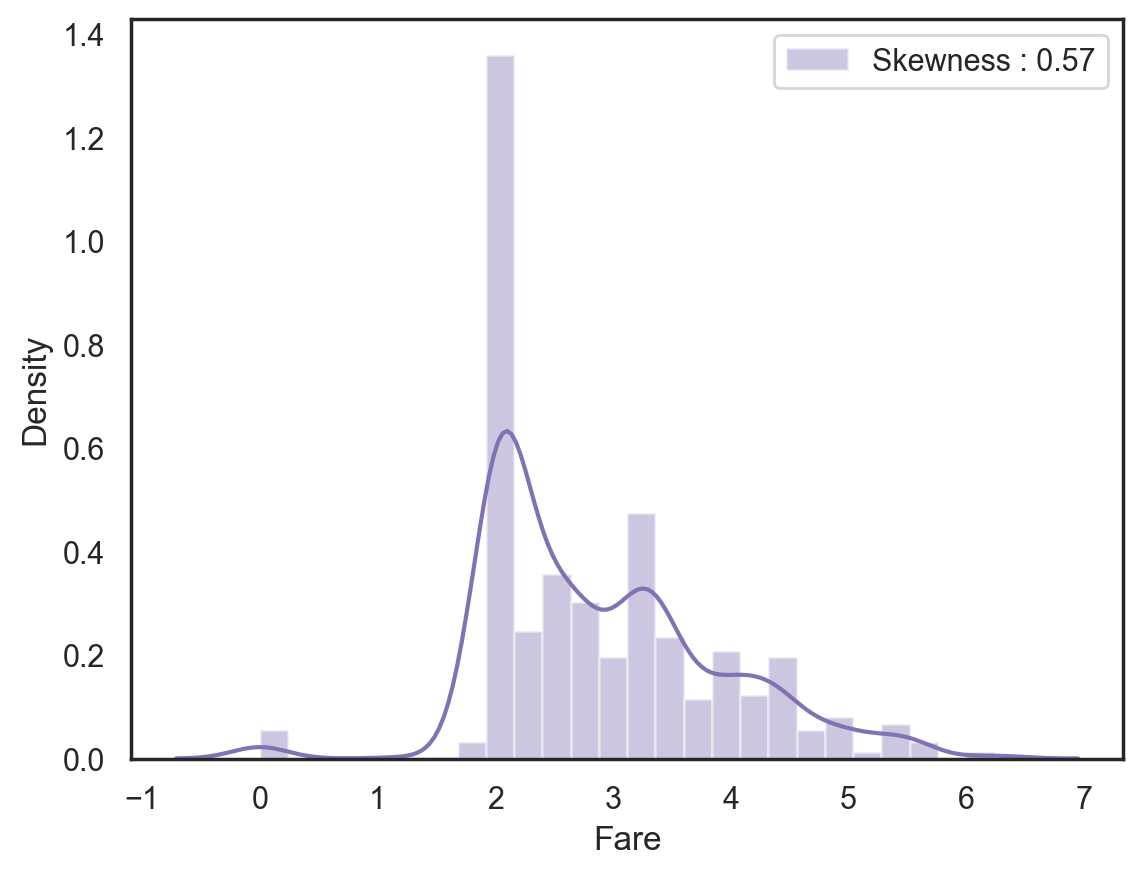

In [50]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')